# Movielens 영화 추천

활용할 dataset 추천 시스템의 MNIST라고 부를만한 Movielens

유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기별로 있으며 Movielens 1M Dataset 사용할 예정 

별점 데이터는 대표적인 explicit/ implicit 데이터로 간주하고 테스트해볼 수 있고 별점을  **시청횟수**로 해석해서 생각할 예정
또한, 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

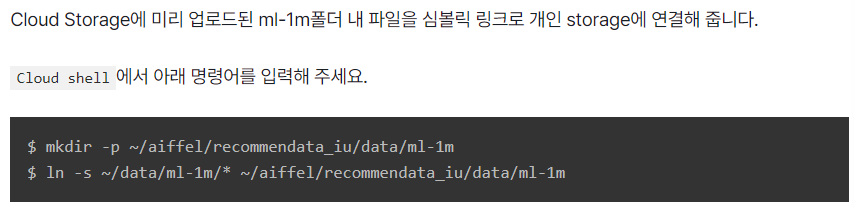

## Step 1. data 준비 및 전처리

In [1]:
import os
import scipy # version : 1.7,1
import implicit # version : 0.4.8
import numpy as np # version : 1.21.4
import pandas as pd # version : 1.3.3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다.

In [2]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp'] # column name이 없어서 생성
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
print (ratings.count())
ratings.head()

user_id      1000209
movie_id     1000209
ratings      1000209
timestamp    1000209
dtype: int64


,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


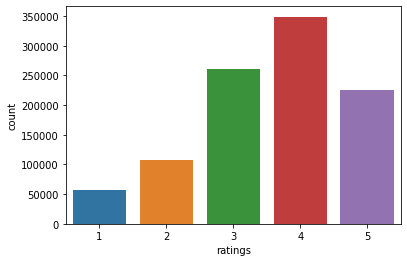

In [3]:
sns.countplot(x='ratings', data=ratings);

* 총 DATA 수는 1000209개

* 별점 데이터의 분포도 중 4점을 준 유저가 많음

---


* 별점을 시청횟수로 해석해서 생각할 예정 또한, 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

- 3점 이상의 데이터만 남깁니다.

* f string 소수점 코드 :.2%

In [4]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


* 파일이름(ratings)와 겹치지 않도록 컬럼 rating의 이름을 count로 바꿉니다.

In [5]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [6]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [7]:
ratings.head()

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


* 사용하지 않는 컬럼 제거
> 본 Dataframe에서는 시간을 고려하지 않음 

In [8]:
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head()

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [9]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


#### ratings 와 movies dataframe 병합

In [10]:
data = pd.merge(ratings,movies, how='outer',on='movie_id') 
data.isnull().sum()

user_id     255
movie_id      0
counts      255
title         0
genre         0
dtype: int64

In [11]:
data.dropna(inplace=True)

---

## Step2. 데이터  탐색 및 분석 


**data에 있는 유니크한 사용자 수**

In [12]:
# 유니크한 사용자 수 
data['user_id'].nunique()

6039

**data에 있는 유니크한 영화 개수**

In [13]:
# 유니크한 영화 개수
data['movie_id'].nunique()

3628

**가장 인기 있는 영화 30개(인기순)**

In [14]:
# 인기 많은 영화
movies_count = data.groupby('movie_id')['user_id'].count()   # 영화별 grouping, 사용자 수를 카운트
movies_count.sort_values(ascending=False).head(30)              # 상위 30편

movie_id
2858    3211
260     2910
1196    2885
1210    2716
2028    2561
589     2509
593     2498
1198    2473
1270    2460
2571    2434
480     2413
2762    2385
608     2371
110     2314
1580    2297
527     2257
1197    2252
2396    2213
1617    2210
318     2194
858     2167
1265    2121
1097    2102
2997    2066
2716    2051
296     2030
356     2022
1240    2019
1       2000
457     1941
Name: user_id, dtype: int64

* id, title을 확인하는 함수 생성

In [15]:
def id_to_title(id):
    return data['title'][data['movie_id']==id].values[0]

In [16]:
id_to_title(5)

'Father of the Bride Part II (1995)'

In [17]:
def title_to_id(title):
    return data['movie_id'][data['title']==title].values[0].item()

In [18]:
title_to_id('Father of the Bride Part II (1995)')

5

In [19]:
movies_30 = movies_count.sort_values(ascending=False).head(30)
movies_30.keys()

Int64Index([2858,  260, 1196, 1210, 2028,  589,  593, 1198, 1270, 2571,  480,
            2762,  608,  110, 1580,  527, 1197, 2396, 1617,  318,  858, 1265,
            1097, 2997, 2716,  296,  356, 1240,    1,  457],
           dtype='int64', name='movie_id')

In [20]:
for idx, i in zip(movies_30.index, movies_30.keys()):
    print(idx, id_to_title(i))

2858 American Beauty (1999)
260 Star Wars: Episode IV - A New Hope (1977)
1196 Star Wars: Episode V - The Empire Strikes Back (1980)
1210 Star Wars: Episode VI - Return of the Jedi (1983)
2028 Saving Private Ryan (1998)
589 Terminator 2: Judgment Day (1991)
593 Silence of the Lambs, The (1991)
1198 Raiders of the Lost Ark (1981)
1270 Back to the Future (1985)
2571 Matrix, The (1999)
480 Jurassic Park (1993)
2762 Sixth Sense, The (1999)
608 Fargo (1996)
110 Braveheart (1995)
1580 Men in Black (1997)
527 Schindler's List (1993)
1197 Princess Bride, The (1987)
2396 Shakespeare in Love (1998)
1617 L.A. Confidential (1997)
318 Shawshank Redemption, The (1994)
858 Godfather, The (1972)
1265 Groundhog Day (1993)
1097 E.T. the Extra-Terrestrial (1982)
2997 Being John Malkovich (1999)
2716 Ghostbusters (1984)
296 Pulp Fiction (1994)
356 Forrest Gump (1994)
1240 Terminator, The (1984)
1 Toy Story (1995)
457 Fugitive, The (1993)


<AxesSubplot:xlabel='title'>

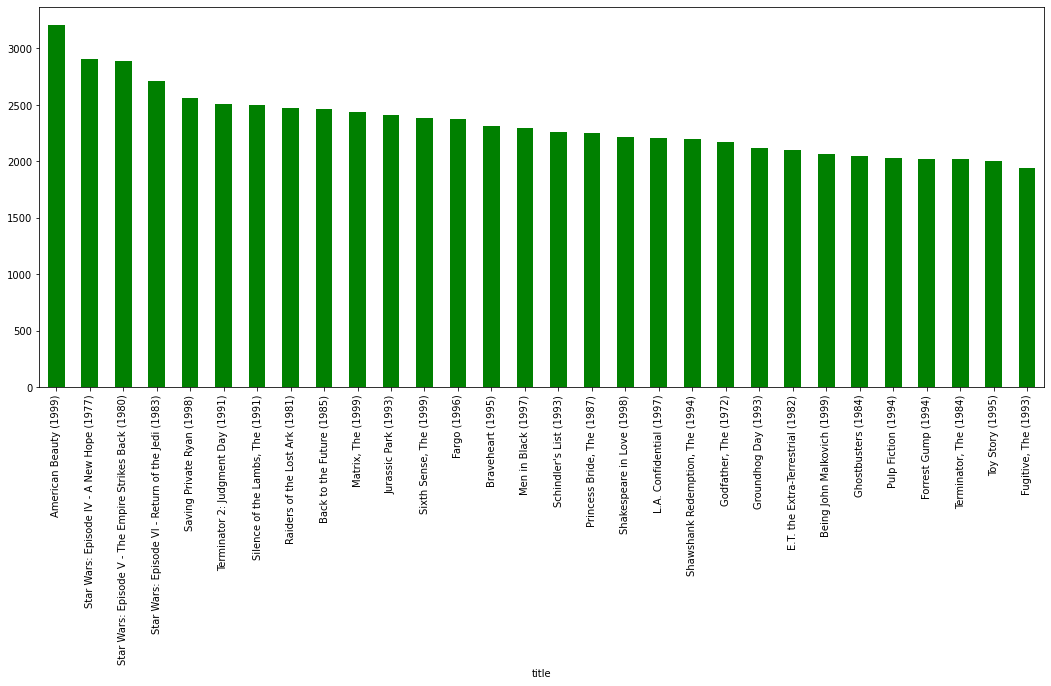

In [21]:
data.groupby('title')['user_id'].count().sort_values(ascending=False).head(30).plot(kind='bar', figsize=(18,7),color='g')

### Data 분석

In [22]:
# 유저별 몇 편의 영화를 봤는지에 대한 통계
user_count = data.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [23]:
# 영화별 평균 시청 횟수 
movie_mean_count = data.groupby('title')['counts'].mean()
movie_mean_count.describe()

count    3628.000000
mean        3.767691
std         0.336912
min         3.000000
25%         3.522566
50%         3.749776
75%         4.000000
max         5.000000
Name: counts, dtype: float64

## Step3. 모델 검증을 위한 데이터 추가

* 내가 선호하는 영화를 5가지 골라서 rating에 추가

In [24]:
# 내가 좋아하는 영화 5편 추가
my_favorite = ['Joker (2019)' , 'Aladdin (2019)' ,'Harry Potter And The Chamber Of Secrets (2002)' ,'Mad City (1997)' ,'Interstellar (2014)']

# 'A'이라는 user_id
my_movielist = pd.DataFrame({'user_id': ['A']*5, 'title': my_favorite, 'counts':[5]*5})
if not data.isin({'user_id':['A']})['user_id'].any():  # user_id에 'A'이라는 데이터가 없다면
    data = data.append(my_movielist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다.
 
data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,movie_id,counts,title,genre
836473,5851.0,3607.0,5.0,One Little Indian (1973),Comedy|Drama|Western
836474,5854.0,3026.0,4.0,Slaughterhouse (1987),Horror
836475,5854.0,690.0,3.0,"Promise, The (Versprechen, Das) (1994)",Romance
836476,5938.0,2909.0,4.0,"Five Wives, Three Secretaries and Me (1998)",Documentary
836477,5948.0,1360.0,5.0,Identification of a Woman (Identificazione di ...,Drama
0,A,NaN,5.0,Joker (2019),NaN
1,A,NaN,5.0,Aladdin (2019),NaN
2,A,NaN,5.0,Harry Potter And The Chamber Of Secrets (2002),NaN
3,A,NaN,5.0,Mad City (1997),NaN
4,A,NaN,5.0,Interstellar (2014),NaN


In [25]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = data['user_id'].unique()
title_unique = data['title'].unique()

# 유저, 영화indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}

In [26]:
# 인덱싱이 잘 되었는지 확인 
print(user_to_idx['A'])  
print(title_to_idx['Joker (2019)'])

6039
3628


In [27]:
for i in range(1, 6040):
    if i in ratings['user_id'].values:
        continue
    else:
        print(i)

3598


In [28]:
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = data['title'].map(title_to_idx.get).dropna()
if len(temp_movie_data) == len(data):
    print('title column indexing OK!!')
    data['title'] = temp_movie_data
else:
    print('title column indexing Fail!!')

data

user_id column indexing OK!!
title column indexing OK!!


,user_id,movie_id,counts,title,genre
0,0,1193.0,5.0,0,Drama
1,1,1193.0,5.0,0,Drama
2,2,1193.0,4.0,0,Drama
3,3,1193.0,4.0,0,Drama
4,4,1193.0,5.0,0,Drama
...,...,...,...,...,...
0,6039,NaN,5.0,3628,NaN
1,6039,NaN,5.0,3629,NaN
2,6039,NaN,5.0,3630,NaN
3,6039,NaN,5.0,2338,NaN


## Step4. CSR(Compressed Sparse Row) matrix 만들기

In [29]:
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_movie = data['title'].nunique()

csr_data = csr_matrix((data['counts'], (data.user_id,data.title)), shape=(num_user, num_movie))
csr_data

<6040x3632 sparse matrix of type '<class 'numpy.float64'>'
	with 836483 stored elements in Compressed Sparse Row format>



## Step5.  als_model = AlternatingLeastSquares 모델 구성과 훈련

In [30]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [31]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=3000, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=50, 
                                    dtype=np.float32)

* AlternatingLeastSquares 클래스의 __init__ 파라미터

> factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지

>regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지

>use_gpu : GPU를 사용할 것인지

>iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

In [32]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3632x6040 sparse matrix of type '<class 'numpy.float64'>'
	with 836483 stored elements in Compressed Sparse Column format>

### 모델 훈련

In [33]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/50 [00:00<?, ?it/s]

## Step6. 선호하는 영화를 이용해 학습된 모델이 예측한 선호도를 확인하기

In [34]:
A, Interstellar = user_to_idx['A'], title_to_idx['Interstellar (2014)']
A_vector, Interstellar_vector = als_model.user_factors[A], als_model.item_factors[Interstellar]

In [35]:
np.dot(A_vector,Interstellar_vector)

0.896357

In [36]:
aladdin = title_to_idx['Aladdin (2019)']
aladdin_vector = als_model.item_factors[aladdin]
np.dot(A_vector, aladdin_vector)

0.8865713

**테스트하기**
1. factors:100 / iteration :15
> 0.00087724894

2. factors:1000 / iteration :15
> 0.09790825

3. factors:1000 / iteration :50
> 0.06269967

4. factors:3000 / iteration :50
> 0.8865713

## Step7. 내가 좋아하는 영화와 비슷한 영화를 추천받기

* AlternatingLeastSquares 클래스에 구현되어 있는 similar_items 메서드를 통하여 비슷한 영화를 찾는다.

* 영화 이름을 입력값으로 받아서 비슷한 영화 5개를 출력해주는 get_similar_movie 함수를 정의

In [37]:
# index로부터 artist 이름을 얻는 dict 생성
idx_to_title = {v:k for k,v in title_to_idx.items()}

def get_similar_movie(movie_name: str):
    movie_id = title_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id, N=5)
    similar_movie = [idx_to_title[i[0]] for i in similar_movie]
    return similar_movie

In [38]:
# " 알라딘"과 비슷한 영화 추천
get_similar_movie('Aladdin (2019)')

['Aladdin (2019)',
 'Harry Potter And The Chamber Of Secrets (2002)',
 'Joker (2019)',
 'Interstellar (2014)',
 'Century (1993)']

In [42]:
get_similar_movie('Interstellar (2014)')

['Interstellar (2014)',
 'Harry Potter And The Chamber Of Secrets (2002)',
 'Joker (2019)',
 'Century (1993)',
 'Aladdin (2019)']

## Step8. 내가 가장 좋아할 만한 영화들을 추천받기

* AlternatingLeastSquares 클래스에 구현되어 있는 recommend 메서드를 통하여 내가 좋아할 만한 영화를 추천받는다.

* filter_already_liked_items 는 유저가 이미 평가한 아이템은 제외하는 Argument

In [43]:
user = user_to_idx['A']

# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)

# 인덱스를 영화 이름으로 mapping
[idx_to_title[i[0]] for i in movie_recommended]

['Second Jungle Book: Mowgli & Baloo, The (1997)',
 'Separation, The (La Séparation) (1994)',
 'Vagabond (Sans toit ni loi) (1985)',
 'Boys (1996)',
 'Pompatus of Love, The (1996)',
 'Death in Brunswick (1991)',
 "Rich Man's Wife, The (1996)",
 'Pie in the Sky (1995)',
 'Big Combo, The (1955)',
 "I Don't Want to Talk About It (De eso no se habla) (1993)",
 'Topaz (1969)',
 'Talk of Angels (1998)',
 'Sticky Fingers of Time, The (1997)',
 'Jerry & Tom (1998)',
 'Little Nemo: Adventures in Slumberland (1992)',
 'Great Locomotive Chase, The (1956)',
 'Tales of Terror (1962)',
 'Prophecy II, The (1998)',
 'Tomb of Ligeia, The (1965)',
 "Dog's Life, A (1920)"]

In [44]:
schindler = title_to_idx["Second Jungle Book: Mowgli & Baloo, The (1997)"]
explain = als_model.explain(user, csr_data, itemid=schindler)

[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('Aladdin (2019)', 0.04512180586184376),
 ('Joker (2019)', 0.039884616121502146),
 ('Interstellar (2014)', 0.005340777493324485),
 ('Mad City (1997)', 0.0007766581055947667),
 ('Harry Potter And The Chamber Of Secrets (2002)', -0.00931936241508039)]

* Separation, The (La Séparation) (1994) 추천에 기여한 정도를 확인한 결과 Aladdin이 제일 높게 나옴
* 비슷한 장르나 비슷한 계열이라서 유사도가 높은것으로 판단

# 회고
* 영화 데이터 중 아는 영화가 없어서 내가 재밌게 봤던 영화들을 새롭게 추가해서 모델학습을 시켰는데 선호도는 좋았으나 막상 추천된 영화들을 보면 어떠한 기준으로 해주는건지 정확한 판단이 어려운것 같다. 아마도  새롭게 데이터를 추가하는 도중에 정해주지 않았던 장르나 movie_id 등으로 기준을 못잡았던게 아닐까하는 생각이 든다. 
정확한 기준만 있다면 추천시스템을 어떤식으로 보강해야할지 방향성이 잡힐것 같고 굉장히 흥미로운 프로젝트였다. 